In [1]:
# LOAD LIBRARIES
from IPython.display import display
import pandas as pd
import yfinance as yf
import datetime as dt
from datetime import timedelta
import numpy as np
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import statistics
import random

In [2]:
# LOAD DATA

# Take in Tickers
sp500 = pd.read_excel("https://www.ssga.com/us/en/individual/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",header=4)
        
# Replace Berkshire Ticker and remove ""-"" to fix download/warning issue
ticks = sp500["Ticker"].dropna().replace(["BRK.B", "BF.B"],["BRK-B", "BF-B"])
ticks = ticks[ticks != "-"].to_list()

# Set time frame for 10 years
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(days=2520)

# Download the data using the above variables
stock_port = yf.download(start=start_date, end=end_date, tickers=ticks)
adj_close_port = stock_port["Adj Close"].dropna(how="all",axis=1)
vol_port = stock_port["Volume"].dropna(how="all",axis=1)
low_port = stock_port["Low"].dropna(how="all",axis=1)

# Downloading benchmark
market_port = yf.download(start=start_date, end=end_date, tickers=["SPY"])
adj_close_spy = market_port["Adj Close"].dropna()


[*********************100%%**********************]  503 of 503 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Z Score Portfolio Trading CLASS
class Z_score_pf_managercore_:
    def __init__(self, adj_close,volume,low):
        self.values1 = adj_close
        self.values2 = volume
        self.values3 = low

    def trend_year(self): # slope of 1 year trend 
        tick_cols = pd.DataFrame(index=adj_close_port.columns)
        for ind in range (1,21):
            tick_cols[ind] = np.polyfit(range(252),self.values1[-252-ind:-ind], 1)[0] 
        tre = tick_cols.mean(axis=1)/tick_cols.mean(axis=1).sum(axis=0)
        return tre
    
    def trend51volume(self): # 51 week volume trend
        tick_cols = pd.DataFrame(index=adj_close_port.columns)
        for ind in range (1,21):
            tick_cols[ind] = np.polyfit(range(247),self.values2[-247-ind:-ind], 1)[0] 
        tre = tick_cols.mean(axis=1)/tick_cols.mean(axis=1).sum(axis=0)
        return tre 
    
    def weekpriceoscillator_4_52(self): # # 4/52 week price oscillator via exp. mov. avg. (EWM) for 4 and 52 week data.
        four_week_ema = self.values1.ewm(span=4, min_periods=4).mean()[-20:].mean() # One mean is procedure to calculate EMW, other mean is to account for 20 day lag.
        fiftytwo_week_ema = self.values1.ewm(span=52, min_periods=52).mean()[-20:].mean()
        price_oscillator = (four_week_ema - fiftytwo_week_ema)/(fiftytwo_week_ema) #  https://trendspider.com/learning-center/the-percentage-price-oscillator-ppo-an-overview/
        price_oscillator = price_oscillator/price_oscillator.sum(axis=0)
        return price_oscillator
    
    def zscore(self): # Calculating z-score by averaging over the normalized momentum factors
        low = self.values3.pct_change(260)[-20:].mean()
        low = low/low.sum(axis=0) #5 Year low
        r = self.values1.pct_change(39*5)[-20:].mean() 
        ret = r/r.sum(axis=0) #39 week return with 20 day lag
        average_zscore = (ret+self.trend_year()+self.trend51volume()+low+self.weekpriceoscillator_4_52())/5
        average_zscore = average_zscore.to_frame()
        return average_zscore.sort_values(by=[0],ascending=False).dropna() # Sorting z scores
    
    def basket(self): # lists short/long baskets
        short = self.zscore()[-15:] # Picks worst rated 15 companies
        long = self.zscore()[0:15:] # Picks best rated 15 companies
        return short.index.tolist(),long.index.tolist()

In [4]:
# CREATE RECORD OF TRADES

# Set up Timing for our Lists
dr_start = end_date-dt.timedelta(365.25*5)
dates = pd.date_range(start = dr_start,end = end_date,freq='M',normalize = True)
date_list_market = dates.delete(0) # month offset
dates = dates.delete(-1) # month offset


# Initializing lists (Monthly and Cumulative)
long_returns_list = []
short_returns_list = []
market_returns_list = []
short_basket_returns_cm_list=[]
long_basket_returns_cm_list=[]
market_returns_cm_list=[]
i=0 # Iteration index counter
for date in dates:
        MF = Z_score_pf_managercore_(adj_close_port[adj_close_port.index<=date],vol_port[vol_port.index<=date],low_port[low_port.index<=date])
        short_basket,long_basket = MF.basket()[0],MF.basket()[1]
        # Monthly Returns
        long_returns_list.append(adj_close_port[adj_close_port.index<=date][long_basket].resample('M').mean().pct_change().mean(axis=1)[-1:].tolist()) 
        short_returns_list.append(adj_close_port[adj_close_port.index<=date][short_basket].resample('M').mean().pct_change().mean(axis=1)[-1:].tolist())
        market_returns_list.append(adj_close_spy[adj_close_spy.index<=date_list_market[i]].resample('M').mean().pct_change()[-1:].tolist())
        # Cumulative returns
        short_basket_returns_cm_list.append(adj_close_port[adj_close_port.index<=date][short_basket].resample('M').mean().pct_change(i+1).mean(axis=1)[-1:].tolist())
        long_basket_returns_cm_list.append(adj_close_port[adj_close_port.index<=date][long_basket].resample('M').mean().pct_change(i+1).mean(axis=1)[-1:].tolist())
        market_returns_cm_list.append(adj_close_spy[adj_close_spy.index<=date_list_market[i]].resample('M').mean().pct_change(i+1)[-1:].tolist())
        i +=1
        
# Resolve Sublists
short_returns_list = [item for sublist in short_returns_list for item in sublist]
long_returns_list = [item for sublist in long_returns_list for item in sublist]
market_returns_list = [item for sublist in market_returns_list for item in sublist]
short_basket_returns_cm_list = [item for sublist in short_basket_returns_cm_list for item in sublist]
long_basket_returns_cm_list = [item for sublist in long_basket_returns_cm_list for item in sublist]
market_returns_cm_list = [item for sublist in market_returns_cm_list for item in sublist]

# Monthly returns vs SPY
tot_return = [x + y for x, y in zip(short_returns_list, long_returns_list)]  # Adding two lists
ret_vs_sp500 = [x - y for x, y in zip(tot_return,market_returns_list)] # Difference of two lists
# Chart 3 calculation
cumulative_return= [x + y for x, y in zip(short_basket_returns_cm_list, long_basket_returns_cm_list)] # Adding two lists

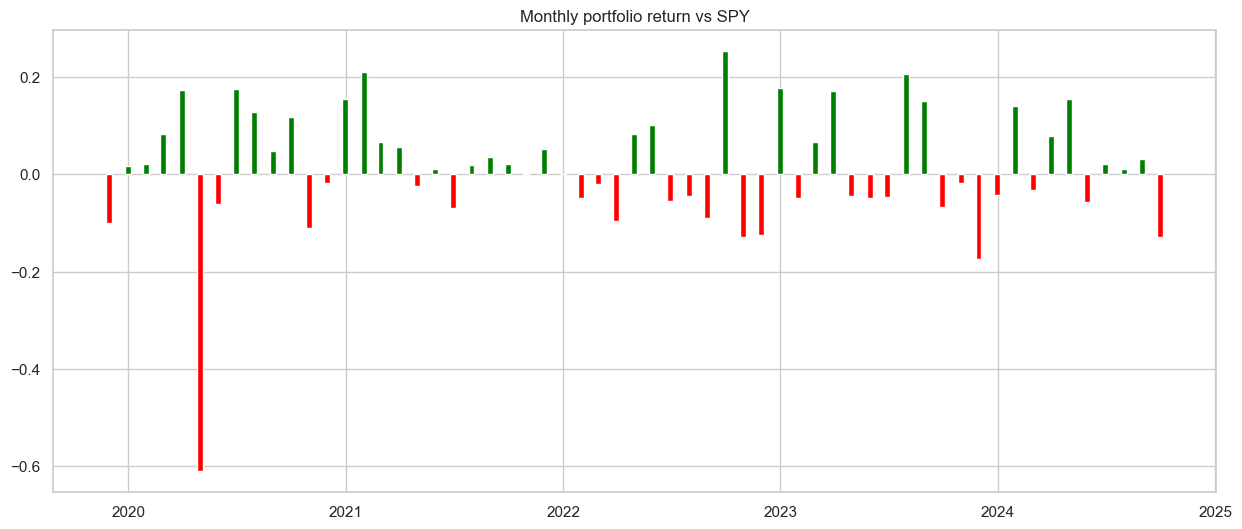

In [5]:
#BAR CHART MONTHLY PORTFOLIO RETURN VS ETF

plt.figure(figsize=(15,6))
colors = ["red" if i < 0 else "green" for i in ret_vs_sp500] 
plt.bar(date_list_market,ret_vs_sp500,width=10,color = colors)
plt.title('Monthly portfolio return vs SPY')
plt.show()

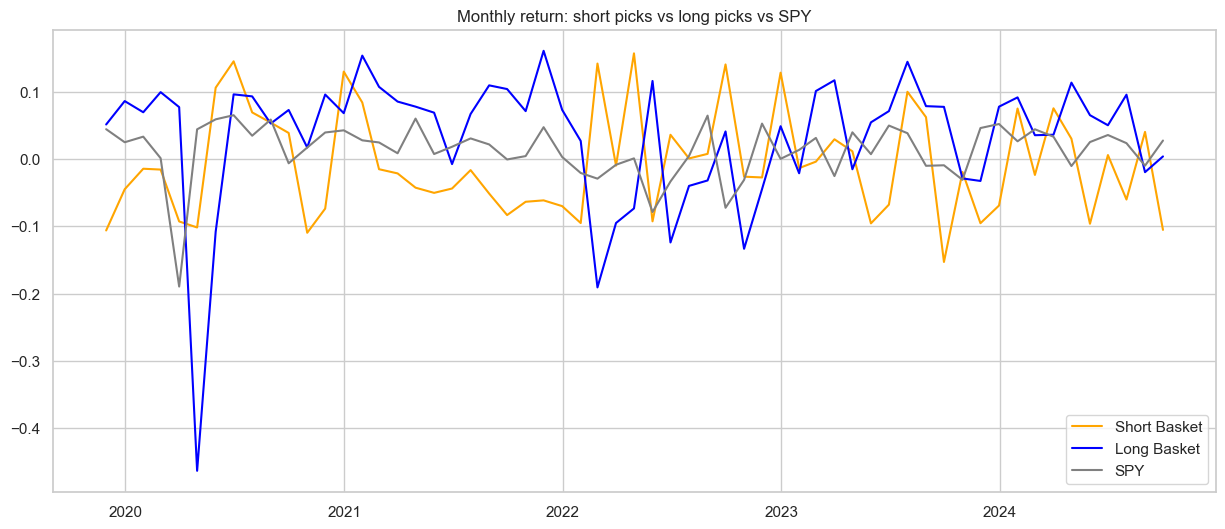

In [6]:
# MONTHLY LONG VS SHORT VS ETF

plt.figure(figsize=(15,6))
plt.plot(date_list_market, short_returns_list,color='orange')
plt.plot(date_list_market, long_returns_list,color='blue')
plt.plot(date_list_market, market_returns_list,color='grey')
plt.title('Monthly return: short picks vs long picks vs SPY')
plt.legend(['Short Basket','Long Basket','SPY'])
plt.show()

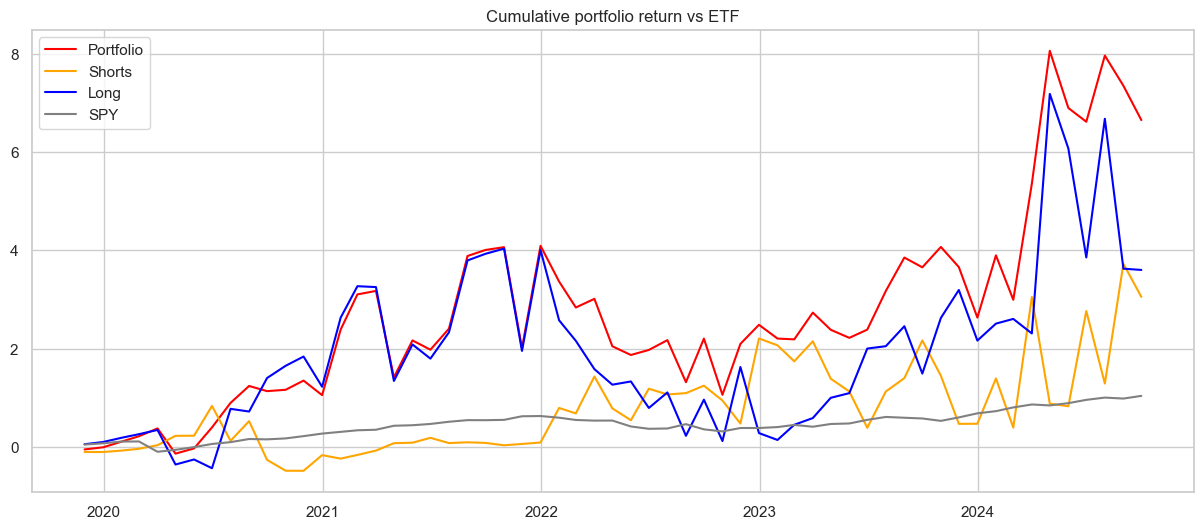

In [7]:
#NOT OFFCIALLY REQUIRED: CUMMULATIVE RETURN PF, LONG, SHORT, ETF

plt.figure(figsize=(15,6))
plt.plot(date_list_market, cumulative_return,color='red')
plt.plot(date_list_market, short_basket_returns_cm_list,color='orange')
plt.plot(date_list_market, long_basket_returns_cm_list,color='blue')
plt.plot(date_list_market, market_returns_cm_list,color='grey')
plt.title('Cumulative portfolio return vs ETF')
plt.legend(['Portfolio','Shorts','Long','SPY'])
plt.show()

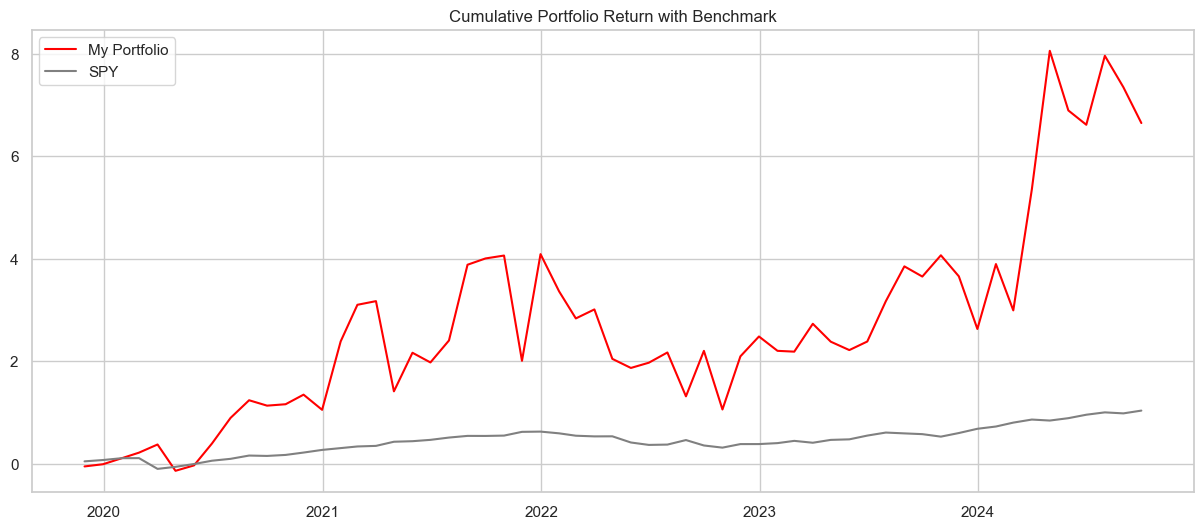

In [8]:
# CUMULATIVE PF RETURN

plt.figure(figsize=(15,6))
plt.plot(date_list_market, cumulative_return,color='red')
plt.plot(date_list_market, market_returns_cm_list,color='grey')
plt.title('Cumulative Portfolio Return with Benchmark')
plt.legend(['My Portfolio','SPY'])
plt.show()